In [3]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19



First we load the desired data from a source we also need to tell the class to download the data

In [4]:
#rki = cov19.data_retrieval.RKI(True)
#rki.download_all_available_data()
import pickle
#pickle.dump(rki, open('rki.pickled', 'wb'))
rki = pickle.load(open('rki.pickled', 'rb'))

Wait for the download to finish. It will print a message!

We can now access this downloaded data by the attribute but normaly one would use the build in filter methods.
```
rki.data
```

In [5]:
df_bundeslaender = rki.filter_all_bundesland('2020-03-10', '2020-04-19')
new_cases_obs = np.diff(np.array(df_bundeslaender),axis=0)[:,:]


date_begin_data = datetime.datetime(2020,3,10)
date_end_data   = datetime.datetime(2020,4,19)
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

prior_date_mild_dist_begin =  datetime.datetime(2020,3,11)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,18)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,25)


change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 0.5,
                     pr_sigma_transient_len=0.5),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 0.5,
                     pr_sigma_transient_len=0.5),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 1.5,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 0.5,
                     pr_sigma_transient_len=0.5)];

In [8]:
params_model = dict(new_cases_obs = new_cases_obs[:],
                    date_begin_data = date_begin_data,
                    num_days_forecast = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 
# normally one would put as N_population an array with the number of inhabitants of 
# of each state

with cov19.Cov19_Model(**params_model) as model:
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4, pr_sigma_lambda_0 = 0.5,
                                                change_points_list = change_points)
    
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8, pr_beta_I_begin=20)
    
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    cov19.student_t_likelihood(new_cases_inferred)


pr_median_transient_len was set to default value 4
pr_median_transient_len was set to default value 4
pr_median_transient_len was set to default value 4


In [10]:
trace = pm.sample(model=model, tune=4000, draws=2000, init='advi+adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 3,265.6:  26%|██▋       | 52566/200000 [02:27<06:54, 355.94it/s]
Convergence achieved at 52600
Interrupted at 52,599 [26%]: Average Loss = 3,899.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_L2_raw, weekend_factor_L1, sigma_weekend_factor_L2, delay_log_L2_raw, delay_log_L1, sigma_delay_L2, I_begin, mu, transient_len_3_log_L2_raw, transient_len_3_log_L1, sigma_transient_len_3_L2, transient_len_2_log_L2_raw, transient_len_2_log_L1, sigma_transient_len_2_L2, transient_len_1_log_L2_raw, transient_len_1_log_L1, sigma_transient_len_1_L2, transient_day_3_L2_raw, transient_day_3_L1, sigma_transient_day_3_L2, transient_day_2_L2_raw, transient_day_2_L1, sigma_transient_day_2_L2, transient_day_1_L2_raw, transient_day_1_L1, sigma_transient_day_1_L2, lambda_3_log_L2_raw, lambda_3_log_L1, sigma_lambda_3_L2, lambda_2_log_L2_raw, lambda_2_log_L1, sigma_lambda_

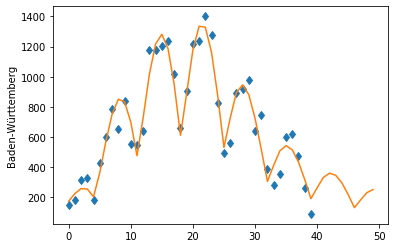

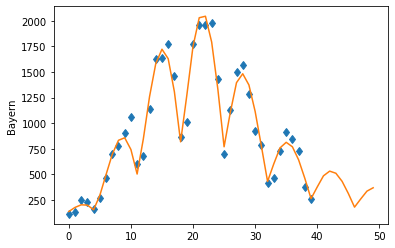

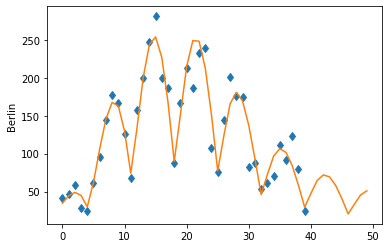

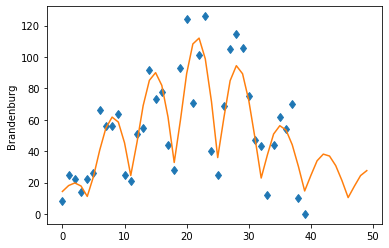

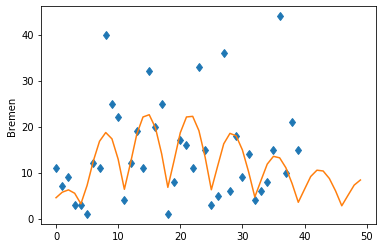

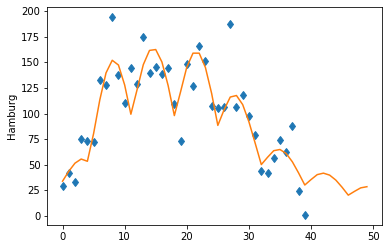

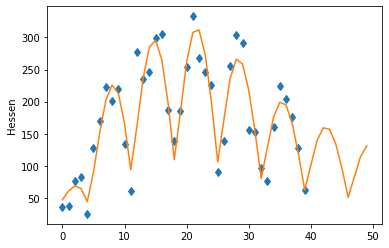

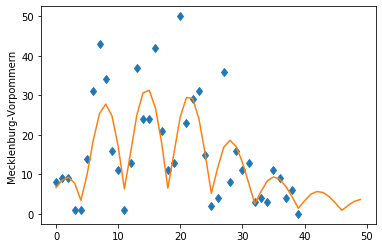

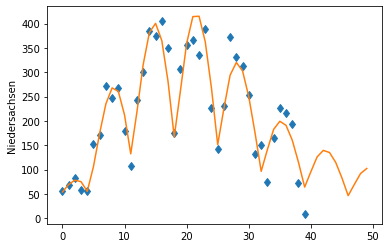

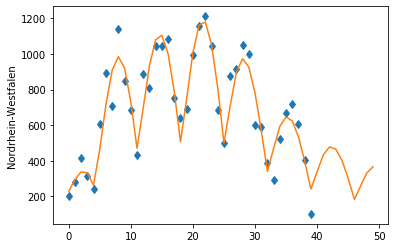

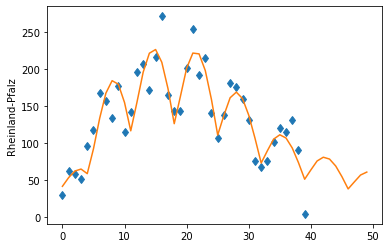

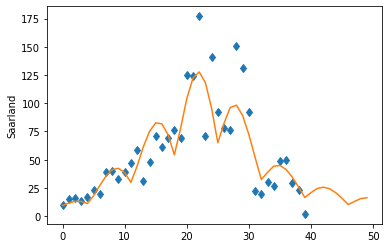

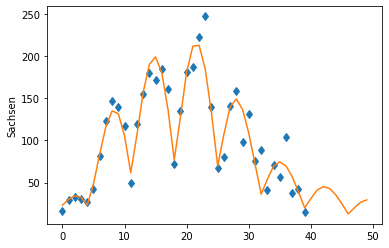

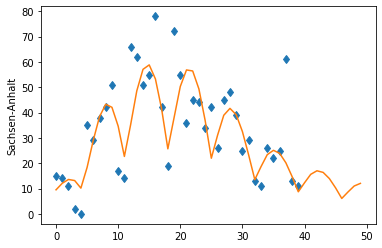

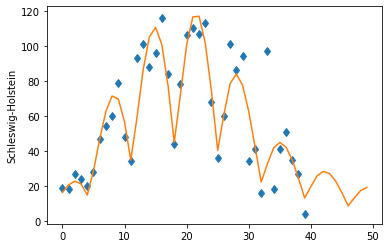

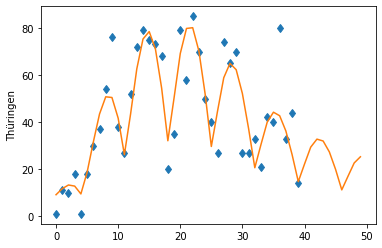

In [21]:
for i in range(16):
    plt.figure()
    plt.plot(new_cases_obs[:,i], 'd')
    plt.plot(np.median(trace.new_cases[:,:,i], axis=0))
    plt.ylabel(df_bundeslaender.columns[i])


Dimension of lambda_0_log_L2_raw larger than one, skipping
Dimension of lambda_1_log_L2_raw larger than one, skipping
Dimension of lambda_2_log_L2_raw larger than one, skipping
Dimension of lambda_3_log_L2_raw larger than one, skipping
Dimension of transient_day_1_L2_raw larger than one, skipping
Dimension of transient_day_2_L2_raw larger than one, skipping
Dimension of transient_day_3_L2_raw larger than one, skipping
Dimension of transient_len_1_log_L2_raw larger than one, skipping
Dimension of transient_len_2_log_L2_raw larger than one, skipping
Dimension of transient_len_3_log_L2_raw larger than one, skipping
Dimension of I_begin larger than one, skipping
Dimension of delay_log_L2_raw larger than one, skipping
Dimension of weekend_factor_L2_raw larger than one, skipping
Dimension of sigma_obs larger than one, skipping


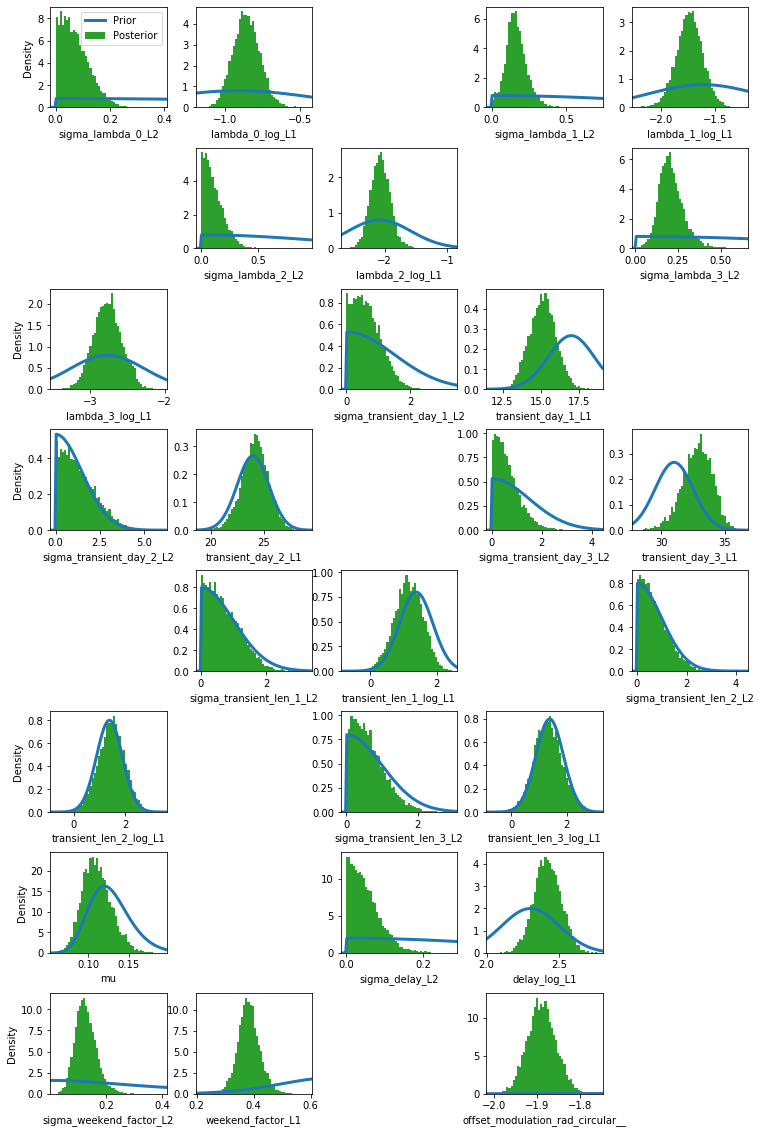

In [14]:
varnames = cov19.plotting.get_all_free_RVs_names(model)
num_cols = 5
num_rows = int(np.ceil(len(varnames)/num_cols))
x_size = num_cols * 2.5
y_size = num_rows * 2.5

fig, axes = plt.subplots(num_rows, num_cols, figsize = (x_size, y_size),squeeze=False)
i_ax = 0
for i_row, axes_row in enumerate(axes):
    for i_col, ax in enumerate(axes_row):
        if i_ax >= len(varnames):
            ax.set_visible(False)
            continue 
        else:
            cov19.plotting.plot_hist(model, trace, ax, varnames[i_ax], 
                                     colors=('tab:blue', 'tab:green'))
        if not i_col == 0:
            ax.set_ylabel('')
        if i_col == 0 and i_row == 0:
            ax.legend()
        i_ax += 1
fig.subplots_adjust(wspace=0.25, hspace=0.4)

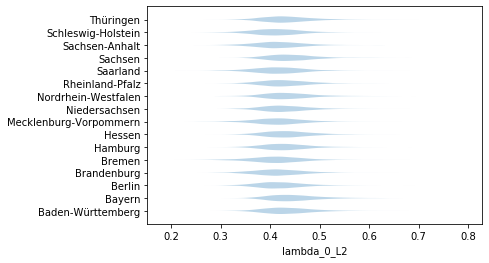

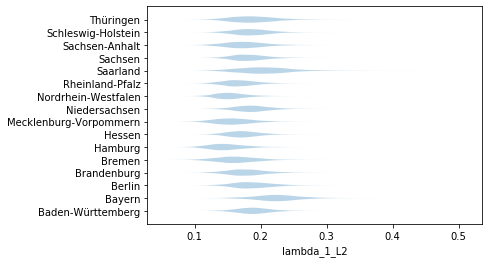

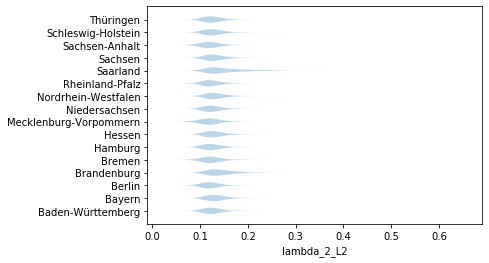

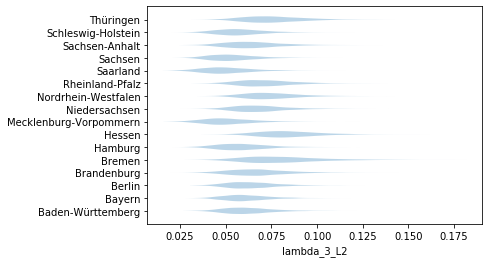

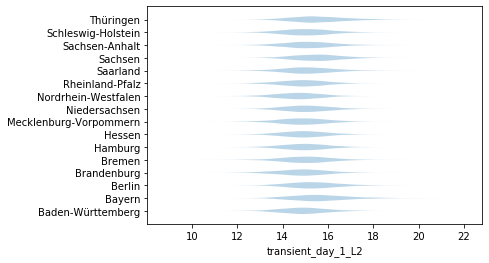

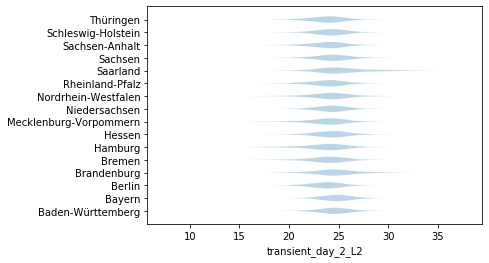

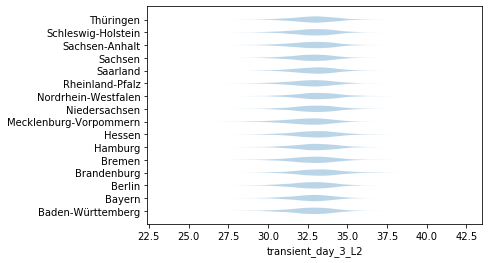

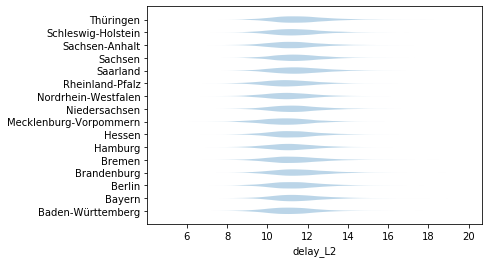

In [17]:
for var_name in ['lambda_0_L2', 'lambda_1_L2', 'lambda_2_L2', 'lambda_3_L2',
                 'transient_day_1_L2', 'transient_day_2_L2', 'transient_day_3_L2', 'delay_L2']:
    f, ax = plt.subplots()
    ax.violinplot(trace[var_name], showextrema=False, vert=False)
    ax.set_yticks(np.arange(1,17))
    ax.set_yticklabels(df_bundeslaender.columns)
    ax.set_xlabel(var_name)